<a href="https://colab.research.google.com/github/JaleelSavoy/DeepLearningProjects/blob/master/DeepClusteringNBAPlayers20162017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Clustering NBA Players (2016-2017 Season)
## Using a Deep Autoencoder and KMeans Clustering

### Introduction
The objective of this notebook is to uncover natural, distinct segments of NBA players, using the players' statistics from the 2016-2017 regular season, and find the common traits of each segment of players. Analyzing natural profiles of NBA players has a clear benefit; for fantasy hoops enthusiasts and basketball operations professionals alike, knowing which players have a similar or dissimilar impact on the game can be incredibly useful information for building teams. The [data source](https://www.kaggle.com/acasalan/nba-player-stats-201718) has the players' age, team, position, season totals, and season salary. To accomplish the goal of discovering hidden structure in the data, the KMeans clustering approach will be performed on latent embeddings from a deep autoencoder. 
  
A benefit of using autoencoders for dimensionality reduction and latent feature extraction is that neural network's hierarchical, nonlinear representation learning of the data should uncover unimportant latent features to be used for the clustering.

When clusters results are interpretted correctly they provide great value, but the interpretation takes a fair amount of domain knowledge. Another thing to consider is that often the natural clusters of data points will not match the researchers idea of how the data should be grouped.

**Note: The description of the data set at the above URL mistakenly describes it as the 2017-2018 regular season, but it is actually data for the 2016-2017 regular season**

### Implementation of the analysis

In [0]:
## Import Relevant packages
import keras                                         # DL framework
import tensorflow as tf                              # DL framework

from keras.models import Model                       # NN Model
from keras.layers import Input, BatchNormalization   # NN Layers
from keras.layers import Activation,Dense            # NN Layers

from sklearn.manifold import TSNE                    # Visualizing high-dimensional data
from sklearn.cluster import KMeans                   # KMeans clustering
from sklearn.preprocessing import MinMaxScaler       # Scale numeric data
from sklearn.preprocessing import normalize          # Normalize numeric data
from sklearn.metrics import silhouette_score         # Silhouette Score
import numpy as np                                   # Scientific computing
import pandas as pd                                  # Data Structures
from matplotlib import pyplot as plt                 # Data visualization

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

np.random.seed(123210)

In [0]:
## Load the data (https://www.kaggle.com/acasalan/nba-player-stats-201718)
from google.colab import files
files.upload()

Saving nbaplayers1718.csv to nbaplayers1718.csv


{'nbaplayers1718.csv': b'#,Season Start,Player Name, Player Salary in $ ,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,blanl,OWS,DWS,WS,WS/48,blank2,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS\r\n24304,2017,A.J. Hammons," $1,312,611.00 ",C,24,DAL,22,0,163,8.4,0.472,0.238,0.476,5.4,20.9,12.8,3.8,0.3,7.2,16.4,17.6,,-0.2,0.2,0,-0.001,,-7.5,1.9,-5.6,-0.1,17,42,0.405,5,10,0.5,12,32,0.38,0.46,9,20,0.45,8,28,36,4,1,13,10,21,48\r\n24165,2017,Aaron Brooks," $2,116,955.00 ",PG,32,IND,65,0,894,9.5,0.507,0.427,0.133,2.3,6.3,4.3,20.7,1.4,0.9,17.2,19.2,,-0.2,0.5,0.3,0.016,,-2.1,-2.6,-4.6,-0.6,121,300,0.403,48,128,0.375,73,172,0.42,0.48,32,40,0.8,18,51,69,125,25,9,66,93,322\r\n24289,2017,Aaron Gordon," $5,504,420.00 ",SF,21,ORL,80,72,2298,14.4,0.53,0.309,0.251,5.3,14.1,9.6,10.5,1.4,1.4,8.5,20.1,,2,1.7,3.7,0.076,,-0.2,-0.4,-0.7,0.8,393,865,0.454,77,267,0.288,316,598,0.53,0.50,156,217,0.719,116,289,405,150,64,40,89

In [0]:
## Import the data
raw_data = pd.read_csv("nbaplayers1718.csv")

## Set the ID columns as the index
raw_data.set_index(["#"], inplace=True)

## Remove useless columns
raw_data.drop(['blanl', 'blank2'], inplace=True, axis=1)

## Add Useful Per Game states
raw_data["PTS_PG"] = raw_data.PTS/raw_data.G
raw_data["PF_PG"]  = raw_data.PF/raw_data.G
raw_data["TOV_PG"] = raw_data.TOV/raw_data.G
raw_data['TRB_PG'] = raw_data.TRB/raw_data.G
raw_data['AST_PG'] = raw_data.AST/raw_data.G
raw_data['STL_PG'] = raw_data.STL/raw_data.G
raw_data['MP_PG']  = raw_data.MP/raw_data.G

In [0]:
## Use a copy of the raw data to initialize the preprocessed data frame
data = raw_data.copy()

## Only analyze players that played at least 15minutes per game and 10 games
data = data[(data.MP_PG >= 15) & (data.G >= 10)]
indexList = data.index

## Save the player name as the index
data.set_index('Player Name')

## Transform the salary column into numeric and put in thousands of USD
data[' Player Salary in $ '] = [
    float(str(i).replace(' $', "").replace(" ", "").replace(",", ""))/1000
    for i in data[' Player Salary in $ ']
]

## Rename the salary column
data.rename(columns={' Player Salary in $ ':'SalaryThousands'}, inplace=True)

## Missing data imputation
data.fillna(data.mean(), inplace=True)

## Scale the data
num_cols = data.columns[data.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
data[num_cols] = MinMaxScaler().fit_transform(data[num_cols])

## Drop the unneeded variables
data.drop(["Player Name", "Tm", 'Pos', 'Season Start'], inplace=True, axis=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 54)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 256)               14080     
_________________________________________________________________
dense_122 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_123 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_124 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_125 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_126 (Dense)            (None, 16)                528       
__________

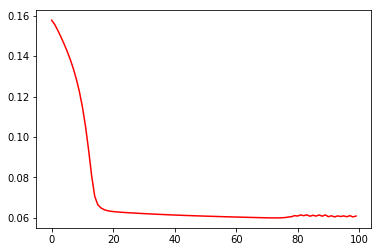

In [0]:
## Autoencoder to get latent embeddings to be used for Kmeans Clustering
# Simple Autoencoder that uses flattened images
ae_input_data = Input(shape=(data.shape[1],))

ae_x1 = Dense(256, activation="relu")(ae_input_data)
ae_x2 = Dense(256, activation="relu")(ae_x1)
ae_x3 = Dense(128, activation="relu")(ae_x2)
ae_x4 = Dense(64, activation="relu")(ae_x3)
ae_x5 = Dense(32, activation="relu")(ae_x4)

ae_encoded = Dense(16, activation="relu")(ae_x5)

ae_x6 = Dense(32, activation="relu")(ae_encoded)
ae_x7 = Dense(64, activation="relu")(ae_x6)
ae_x8 = Dense(128, activation="relu")(ae_x7)
ae_x9 = Dense(256, activation="relu")(ae_x8)
ae_x10 = Dense(256, activation="relu")(ae_x9)

ae_output_data = Dense(data.shape[1], activation='relu')(ae_x10)

model = keras.Model(ae_input_data, ae_output_data)
encoder = Model(ae_input_data, ae_encoded)

model.compile(optimizer='adadelta', loss='mse')
history = model.fit(data,
                    data,
                    epochs=100,
                    batch_size=512,
                    verbose=0,
                    shuffle=True)
encoded_data = pd.DataFrame(encoder.predict(data))
player_clusters = KMeans(n_clusters=10, random_state=123).fit(encoded_data).labels_

model.summary()
encoder.summary()

# visualizing losses and accuracy
train_loss = history.history['loss']
xc = range(len(history.history['loss']))

plt.figure()
plt.plot(xc, train_loss, c="red")

In [0]:
##  Reduce dimensions for visualizing the clusters
data_TSNE = pd.DataFrame(TSNE(n_components=2, 
                random_state=123,
                perplexity=65,
                early_exaggeration=5).fit_transform(encoded_data))
data_TSNE.columns = ["TSNE 1", "TSNE 2"]
data_TSNE.set_index(indexList, inplace=True)

In [0]:
data_TSNE['Clusters'] = player_clusters

## Features we are interested in
relevant_cols = ['Player Name', "Age", "Pos", "Tm", 'MP_PG', 'PTS_PG',
                 'TRB_PG', 'AST_PG', 'STL_PG', 'TOV_PG', 'PF_PG', 'G',
                 'GS', 'MP', 'PER']

## final data
final_data = raw_data[relevant_cols].merge(data_TSNE,left_index=True, right_index=True)

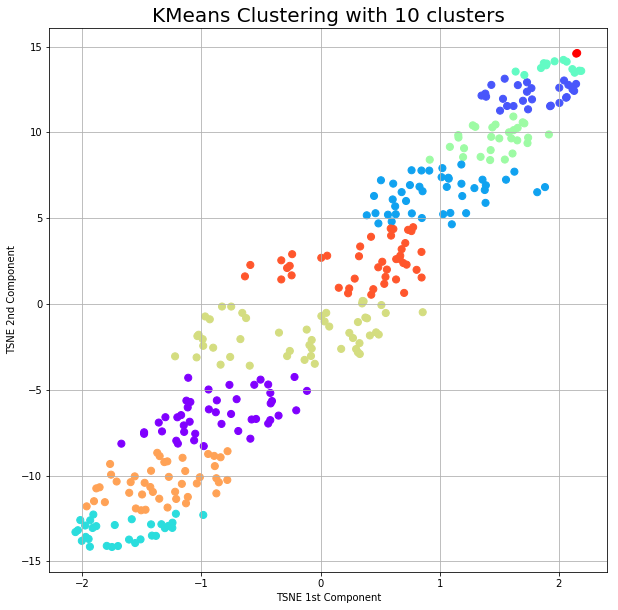

In [0]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('TSNE 1st Component')
ax.set_ylabel('TSNE 2nd Component')
ax.set_title("KMeans Clustering with 10 clusters", fontsize=20)
ax.scatter(data_TSNE['TSNE 1'],
           data_TSNE['TSNE 2'],
           c=data_TSNE['Clusters'],
           cmap='rainbow', s=50)
ax.grid()

In [0]:
final_data[['Clusters','Age', 'MP_PG', 'PTS_PG',
            'TRB_PG', 'AST_PG', 'STL_PG', 'TOV_PG',
            'PF_PG', 'G','GS', 'MP', 'PER']].groupby("Clusters").median()
final_data[['Clusters', "PER"]].groupby("Clusters").count()

,PER
Clusters,
0,44
1,28
2,42
3,30
4,13
5,28
6,50
7,44
8,42


In [0]:
## Analyze the clusters that have the most elite median stat values
print("Cluster with the highest PER")
display(final_data[final_data.Clusters == 9].sort_values(by=["PER", "PTS_PG", "AST_PG", "TRB_PG","STL_PG"], ascending=False))
print("\n\nCluster with the second highest PER")
display(final_data[final_data.Clusters == 4].sort_values(by=["PER", "PTS_PG", "AST_PG", "TRB_PG","STL_PG"], ascending=False))

Cluster with the highest PER


,Player Name,Age,Pos,Tm,MP_PG,PTS_PG,TRB_PG,AST_PG,STL_PG,TOV_PG,PF_PG,G,GS,MP,PER,TSNE 1,TSNE 2,Clusters
#,,,,,,,,,,,,,,,,,,
24654,Russell Westbrook,28,PG,OKC,34.592593,31.580247,10.666667,10.370370,1.641975,5.407407,2.345679,81,81,2802,30.6,2.154476,14.625408,9
24306,James Harden,27,PG,HOU,36.382716,29.086420,8.135802,11.185185,1.481481,5.728395,2.654321,81,81,2947,27.3,2.146616,14.590261,9




Cluster with the second highest PER


,Player Name,Age,Pos,Tm,MP_PG,PTS_PG,TRB_PG,AST_PG,STL_PG,TOV_PG,PF_PG,G,GS,MP,PER,TSNE 1,TSNE 2,Clusters
#,,,,,,,,,,,,,,,,,,
24239,Kevin Durant,28,SF,GSW,33.387097,25.080645,8.274194,4.838710,1.064516,2.225806,1.887097,62,62,2070,27.6,1.711036,13.344510,4
24218,Anthony Davis,23,C,NOP,36.106667,27.986667,11.813333,2.093333,1.253333,2.413333,2.240000,75,75,2708,27.5,1.898716,14.010582,4
24414,Kawhi Leonard,25,SF,SAS,33.432432,25.513514,5.810811,3.513514,1.783784,2.081081,1.648649,74,74,2474,27.5,1.850741,13.750794,4
24365,LeBron James,32,SF,CLE,37.756757,26.405405,8.648649,8.729730,1.243243,4.094595,1.810811,74,74,2794,27.0,2.039039,14.224084,4
24612,Isaiah Thomas,27,PG,BOS,33.802632,28.934211,2.697368,5.907895,0.921053,2.763158,2.197368,76,76,2569,26.5,2.188400,13.582770,4
24115,Giannis Antetokounmpo,22,SF,MIL,35.562500,22.900000,8.750000,5.425000,1.637500,2.925000,3.075000,80,80,2845,26.1,1.964758,14.142960,4
24625,Karl-Anthony Towns,21,C,MIN,36.951220,25.134146,12.280488,2.682927,0.695122,2.585366,2.939024,82,82,3030,26.0,1.874330,14.031393,4
24206,DeMarcus Cousins,26,C,TOT,34.236111,26.972222,11.069444,4.611111,1.388889,3.736111,3.861111,72,72,2465,25.7,1.893802,13.910228,4
24175,Jimmy Butler,27,SF,CHI,36.960526,23.894737,6.184211,5.486842,1.881579,2.092105,1.473684,76,75,2809,25.1,2.114268,13.687820,4


In [0]:
## Analyze the clusters that have the middle-tier median stat values
print("\n\nSample of cluster with the third highest PER")
display(final_data[final_data.Clusters == 1].sort_values(by=["PER", "PTS_PG", "AST_PG", "TRB_PG","STL_PG"], ascending=False)["Player Name"].head(10))
print("\n\nSample of cluster with the fourth highest PER")
display(final_data[final_data.Clusters == 2].sort_values(by=["PER", "PTS_PG", "AST_PG", "TRB_PG","STL_PG"], ascending=False)["Player Name"].head(10))
print("\n\nSample of cluster with the fifth highest PER")
display(final_data[final_data.Clusters == 8].sort_values(by=["PER", "PTS_PG", "AST_PG", "TRB_PG","STL_PG"], ascending=False)["Player Name"].head(10))
print("\n\nSample of cluster with the sixth highest PER")
display(final_data[final_data.Clusters == 6].sort_values(by=["PER", "PTS_PG", "AST_PG", "TRB_PG","STL_PG"], ascending=False)["Player Name"].head(10))



Sample of cluster with the third highest PER


#
24380        Nikola Jokic
24522          Chris Paul
24226       DeMar DeRozan
24201         Mike Conley
24360        Kyrie Irving
24429          Kyle Lowry
24302       Blake Griffin
24657    Hassan Whiteside
24321      Gordon Hayward
24389      DeAndre Jordan
Name: Player Name, dtype: object



Sample of cluster with the fourth highest PER


#
24244      Joel Embiid
24392      Enes Kanter
24182     Clint Capela
24469      Greg Monroe
24274        Pau Gasol
24334      George Hill
24517    Jabari Parker
24643      Dwyane Wade
24562     Derrick Rose
24686      Cody Zeller
Name: Player Name, dtype: object



Sample of cluster with the fifth highest PER


#
24253    Kenneth Faried
24550     Zach Randolph
24412         David Lee
24500      Jusuf Nurkic
24191    Tyson Chandler
24515     Zaza Pachulia
24221    Dewayne Dedmon
24159     Trevor Booker
24131       Will Barton
24409         Ty Lawson
Name: Player Name, dtype: object



Sample of cluster with the sixth highest PER


#
24507         Kyle O'Quinn
24494         Nerlens Noel
24422           Jeremy Lin
24309     Montrezl Harrell
24333         Nene Hilario
24325    Willy Hernangomez
24341       Richaun Holmes
24275             Rudy Gay
24593    Marreese Speights
24541        Dwight Powell
Name: Player Name, dtype: object

### Results
The results of the clustering indicate that the players are grouped into clusters based on their overall impact across the game; this is supported by the fact that players with very different playing styles and positions are grouped together, but the players grouped to together have similar statistics (like PPG, MPG, TRPG, and PER).


The three most impressive clusters were very intuitive in terms of performance-level. The cluster with the highest median PER was cluster nine and it was made up of Russel Westbrook and James Harden, the MVP and the runner-up for MVP for the season. The cluster with the secondest highest PER was cluster four and it was contains the next eight runner-ups for the MVP that year (Kawhi Leonard, Lebron James, Isaiah Thomas, Stephen Curry, Giannis Antetokounmpo, John Wall, Anthony Davis, and Kevin Durant). 
  

These first two cluster would make up an hypothetical first-tier of elite players, followed by cluster one as the second-tier of players and cluster two as the third-tier. After the third-tier, is becomes more difficult to compare the clusters, but the remaining clusters are mainly made up of serviceable backups and role players.